In [116]:
import torch
import torchvision
import matplotlib.pyplot as plt

import torchvision.datasets as Datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [6]:
dataset = Datasets.MNIST(root='data/', download=True)

In [7]:
test=Datasets.MNIST(root='data/',train=False)

In [8]:
len(dataset)

60000

In [9]:
len(test)

10000

In [17]:
dataset[0][0]

In [15]:
dataset[0][1]

5

In [19]:
dataset=Datasets.MNIST(root='data/',
                      train=True,
                      transform=transforms.ToTensor())

In [150]:
test=Datasets.MNIST(root='data/',
                      train=False,
                      transform=transforms.ToTensor())

In [24]:
print(dataset[0][0].shape)
print(dataset[0][1])

torch.Size([1, 28, 28])
5


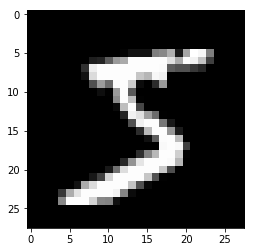

In [32]:
img, label = dataset[0]
plt.imshow(img[0,:,:],cmap='gray')

In [36]:
train, val = random_split(dataset,[45000,15000])
len(train), len(val)

(45000, 15000)

In [77]:
batch_size=128
input_size=28*28
num_classes=10

train_loader = DataLoader(train,batch_size,shuffle=True)
val_loader = DataLoader(val,batch_size)

In [127]:
input_size=28*28
num_classes=10

class MnistModel (nn.Module):
    def __init__(self):
        super().__init__()
        self.linear=nn.Linear(input_size,num_classes)
 
    
    def forward(self,batch_img):
        batch_img=batch_img.reshape(-1,28*28)
        out=self.linear(batch_img)

        return out
model=MnistModel()

In [128]:
model.linear.weight.shape
model.linear.bias.shape

torch.Size([10])

In [129]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0335,  0.0185,  0.0311,  ...,  0.0265,  0.0200, -0.0127],
         [ 0.0352,  0.0213, -0.0044,  ...,  0.0224,  0.0321, -0.0302],
         [-0.0054, -0.0248,  0.0199,  ..., -0.0029,  0.0012, -0.0065],
         ...,
         [-0.0096,  0.0045,  0.0140,  ..., -0.0125, -0.0057,  0.0162],
         [ 0.0244, -0.0229,  0.0048,  ...,  0.0324, -0.0014, -0.0145],
         [-0.0198, -0.0087, -0.0037,  ...,  0.0284,  0.0074,  0.0222]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0196,  0.0194, -0.0040, -0.0033, -0.0022, -0.0265,  0.0329, -0.0103,
          0.0279, -0.0301], requires_grad=True)]

In [134]:
for images,labels in train_loader:
    output=model(images)
    break

In [135]:
def accuracy(outputs,labels):
    _, preds = torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [136]:
accuracy(outputs,labels)

tensor(0.1406)

In [137]:
loss_fn = F.cross_entropy
loss = loss_fn(outputs,labels)

In [138]:
print(loss)

tensor(2.3489, grad_fn=<NllLossBackward>)


In [139]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

In [140]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [141]:
result = evaluate(model,val_loader)
print(result)

{'val_loss': 2.3492038249969482, 'val_acc': 0.08701889216899872}


In [143]:
fit(5, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7945, val_acc: 0.8381
Epoch [1], val_loss: 0.6511, val_acc: 0.8549
Epoch [2], val_loss: 0.5801, val_acc: 0.8626
Epoch [3], val_loss: 0.5369, val_acc: 0.8675
Epoch [4], val_loss: 0.5070, val_acc: 0.8720


In [168]:
model.eval()

MnistModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

In [162]:
img, label = test[4]

In [166]:
def predict(img,model):
    xb=img.unsqueeze(0)
    yb=model(xb)
    _, preds = torch.max(yb,dim=1)
    return preds[0].item()

In [167]:
results=predict(img,model)
print(label,results)

4 4


In [169]:
test_loader = DataLoader(test, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.46939367055892944, 'val_acc': 0.882031261920929}